In [545]:
# %load ../start.py
# Imports
import os
import sys
from pathlib import Path
import re

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../../lib')
from larval_gonad.notebook import Nb
from larval_gonad.plotting import TSNEPlot, make_figs

# Setup notebook
nbconfig = Nb.setup_notebook('2017-12-05_testis_plots_for_brian')
nbconfig.fig_dir = '../../output/figures/2017-12-05_for_brian'
Path(nbconfig.fig_dir).mkdir(exist_ok=True)

# Turn on cache
from joblib import Memory
memory = Memory(cachedir=nbconfig.cache, verbose=0)
mpl.rcParams['svg.fonttype'] = 'none'

last updated: 2017-12-05 
Git hash: 0585cdd8da340735df5064296121559fb4efbbfd


# Testis

In [237]:
tsne = pd.read_csv('../../output/testes_scRNAseq_pilot/tsne.tsv', sep='\t')
clusters = pd.read_csv('../../output/testes_scRNAseq_pilot/clusters.tsv', sep='\t')
norm = pd.read_csv('../../output/testes_scRNAseq_pilot/normalized_read_counts.tsv', sep='\t').T
raw = pd.read_csv('../../output/testes_scRNAseq_pilot/raw.tsv', sep='\t').T

CHROMS = ['chrX', 'chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrY']
AUTOSOMES = ['chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4']
REF = os.environ['REFERENCES_DIR']


annot = pd.read_csv('/data/LCDB/lcdb-references/dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation', sep='\t', usecols=['primary_FBgn', 'gene_symbol'])
fbgn2symbol = annot.set_index('primary_FBgn').to_dict()['gene_symbol']
symbol2fbgn = annot.set_index('gene_symbol').to_dict()['primary_FBgn']

# Create fbgn2chrom
genes = []
with Path(REF, 'dmel/r6-16/gtf/dmel_r6-16.gtf').open() as fh:
    for row in fh:
        rows = row.strip().split()
        
        if len(rows) == 0:
            continue
            
        if rows[2] == 'gene':
            genes.append((rows[0], rows[9].replace('"', '').replace(';', '')))

fbgn2chrom = pd.DataFrame(genes, columns=['chrom', 'FBgn'])
fbgn2chrom.set_index('FBgn', inplace=True)
fbgn2chrom = fbgn2chrom[fbgn2chrom['chrom'].isin(CHROMS)]

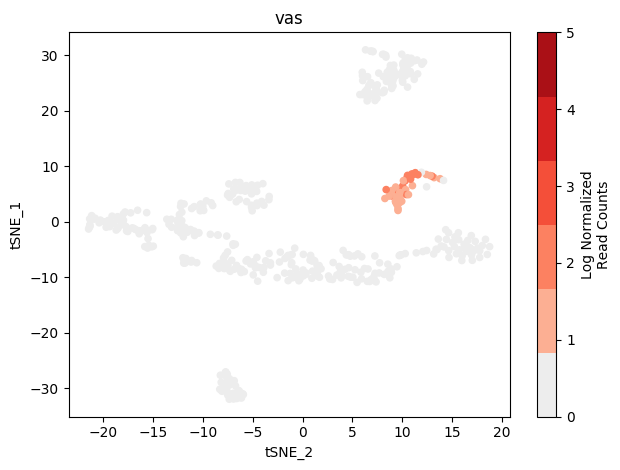

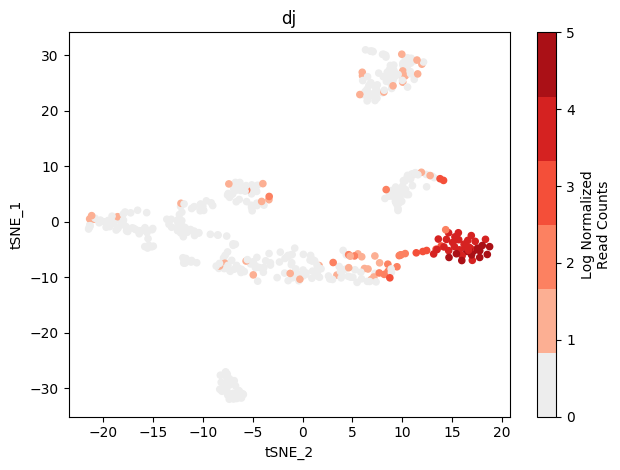

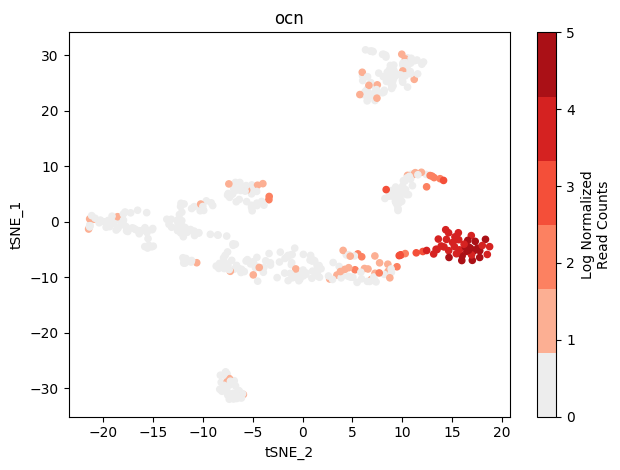

In [78]:
def testis_tsne(gene):
    @make_figs(nbconfig.fig_name(f'testis_tsne_{gene}'), styles=['notebook-wide', 'talk-wide'], formats=['png', 'pdf'])
    def _plot(gene):
        fig, ax = plt.subplots(1, 1)
        palette = sns.color_palette('Reds')
        palette[0] = sns.color_palette('Greys')[0]
        TSNEPlot('tSNE_2', 'tSNE_1', data=tsne.join(norm), hue=symbol2fbgn[gene], palette=palette, alpha=1, title=gene, ax=ax)
        cax = fig.get_axes()[1]
        cax.set_ylabel('Log Normalized\nRead Counts')
    _plot(gene)

testis_tsne('vas')
testis_tsne('dj')
testis_tsne('ocn')

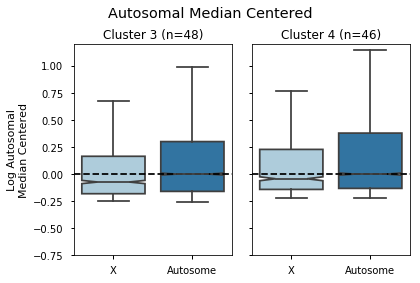

In [228]:
@make_figs(nbconfig.fig_name('boxplot'), )
def plot_boxplots(cluster=3, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    _cluster = norm[norm.join(clusters).ident == cluster]
    _n = _cluster.shape[0]
    expressed = (_cluster > 0).sum() > 3
    _chrom = _cluster.T[expressed].join(fbgn2chrom)

    _x = _chrom[_chrom.chrom == 'chrX'].drop('chrom', axis=1).mean(axis=1)
    _x.name = 'X'

    _a = _chrom[_chrom.chrom.isin(AUTOSOMES)].drop('chrom', axis=1).mean(axis=1)
    _a.name = 'Autosome'

    _amed = _a.median()

    sns.boxplot(data=pd.concat([_x - _amed, _a - _amed], axis=1), fliersize=0, notch=True, ax=ax)
    ax.set_ylim(-.75, 1.2)
    ax.axhline(0, ls='--', c='k')
    ax.set_title(f'Cluster {cluster} (n={_n})')
    

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
plot_boxplots(3, ax=ax1)
plot_boxplots(4, ax=ax2)
plt.suptitle('Autosomal Median Centered')
ax1.set_ylabel('Log Autosomal\nMedian Centered')
fig.tight_layout(rect=[0, 0, 1, .95])

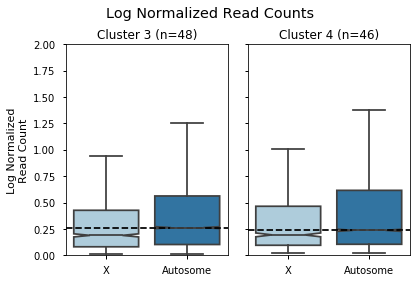

In [233]:
def plot_boxplots(cluster=3, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    _cluster = norm[norm.join(clusters).ident == cluster]
    _n = _cluster.shape[0]
    expressed = (_cluster > 0).sum() > 3
    _chrom = _cluster.T[expressed].join(fbgn2chrom)

    _x = _chrom[_chrom.chrom == 'chrX'].drop('chrom', axis=1).mean(axis=1)
    _x.name = 'X'

    _a = _chrom[_chrom.chrom.isin(AUTOSOMES)].drop('chrom', axis=1).mean(axis=1)
    _a.name = 'Autosome'
    _amed = _a.median()

    sns.boxplot(data=pd.concat([_x, _a], axis=1), fliersize=0, notch=True, ax=ax)
    ax.axhline(_amed, ls='--', c='k')
    ax.set_title(f'Cluster {cluster} (n={_n})')
    
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
plot_boxplots(3, ax=ax1)
plot_boxplots(4, ax=ax2)
plt.suptitle('Log Normalized Read Counts')
ax1.set_ylabel('Log Normalized\nRead Count')
ax1.set_ylim(0, 2)
fig.tight_layout(rect=[0, 0, 1, .95])

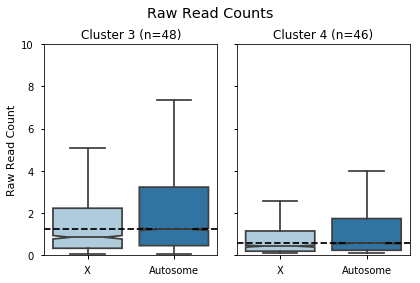

In [246]:
def plot_boxplots(cluster=3, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    _cluster = raw[raw.join(clusters).ident == cluster]
    _n = _cluster.shape[0]
    expressed = (_cluster > 0).sum() > 3
    _chrom = _cluster.T[expressed].join(fbgn2chrom)

    _x = _chrom[_chrom.chrom == 'chrX'].drop('chrom', axis=1).mean(axis=1)
    _x.name = 'X'

    _a = _chrom[_chrom.chrom.isin(AUTOSOMES)].drop('chrom', axis=1).mean(axis=1)
    _a.name = 'Autosome'
    _amed = _a.median()

    sns.boxplot(data=pd.concat([_x, _a], axis=1), fliersize=0, notch=True, ax=ax)
    ax.axhline(_amed, ls='--', c='k')
    ax.set_title(f'Cluster {cluster} (n={_n})')
    
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
plot_boxplots(3, ax=ax1)
plot_boxplots(4, ax=ax2)
plt.suptitle('Raw Read Counts')
ax1.set_ylabel('Raw Read Count')
ax1.set_ylim(0, 10)
fig.tight_layout(rect=[0, 0, 1, .95])

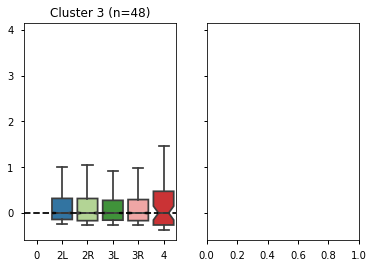

In [340]:
def plot_boxplots(cluster=3, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    _cluster = norm[norm.join(clusters).ident == cluster]
    _n = _cluster.shape[0]
    expressed = (_cluster > 0).sum() > 3
    
    _chrom = _cluster.T[expressed].join(fbgn2chrom)
    _chrom = _chrom[~_chrom.chrom.isnull()].copy()
    _chrom.chrom = [x.lstrip('chr') for x in _chrom.chrom]

    _x = _chrom[_chrom.chrom == 'chrX'].drop('chrom', axis=1).mean(axis=1)
    _x.name = 'X'

    _a = _chrom[_chrom.chrom.isin([x.lstrip('chr') for x in AUTOSOMES])].set_index('chrom', append=True).mean(axis=1).unstack()
    _a.name = 'Autosome'
    _amed = _a.median()
    _a, _x

    sns.boxplot(data=pd.concat([_x - _amed, _a - _amed], axis=1), fliersize=0, notch=True, ax=ax)
    ax.axhline(0, ls='--', c='k')
    ax.set_title(f'Cluster {cluster} (n={_n})')
    
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
bob = plot_boxplots(3, ax=ax1)
#plot_boxplots(4, ax=ax2)
#plt.suptitle('Autosomal Median Centered\nRead Counts')
#ax1.set_ylabel('Autosomal Median Centered\nRead Count')
#ax1.set_ylim(-1, 2)
#fig.tight_layout(rect=[0, 0, 1, .90])

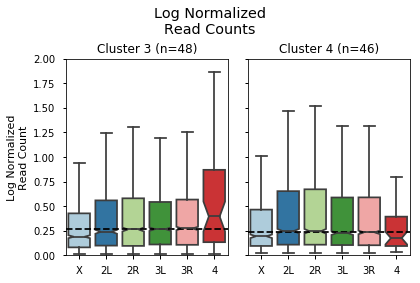

In [334]:
def plot_boxplots(cluster=3, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    _cluster = norm[norm.join(clusters).ident == cluster]
    _n = _cluster.shape[0]
    expressed = (_cluster > 0).sum() > 3
    
    _chrom = _cluster.T[expressed].join(fbgn2chrom)
    _chrom = _chrom[~_chrom.chrom.isnull()].copy()
    _chrom.chrom = [x.lstrip('chr') for x in _chrom.chrom]

    _x = _chrom[_chrom.chrom == 'X'].drop('chrom', axis=1).mean(axis=1)
    _x.name = 'X'

    _a = _chrom[_chrom.chrom.isin([x.lstrip('chr') for x in AUTOSOMES])].set_index('chrom', append=True).mean(axis=1).unstack()
    _a.name = 'Autosome'
    _amed = _a.median().median()

    sns.boxplot(data=pd.concat([_x, _a], axis=1), fliersize=0, notch=True, ax=ax)
    ax.axhline(_amed, ls='--', c='k')
    ax.set_title(f'Cluster {cluster} (n={_n})')
    
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
plot_boxplots(3, ax=ax1)
plot_boxplots(4, ax=ax2)
plt.suptitle('Log Normalized\nRead Counts')
ax1.set_ylabel('Log Normalized\nRead Count')
ax1.set_ylim(0, 2)
fig.tight_layout(rect=[0, 0, 1, .90])

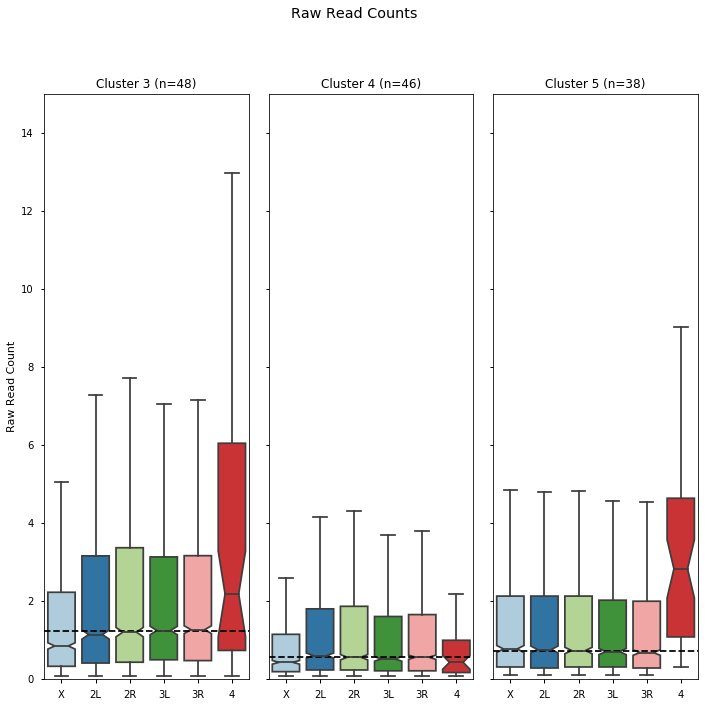

In [343]:
def plot_boxplots(cluster=3, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    _cluster = raw[raw.join(clusters).ident == cluster]
    _n = _cluster.shape[0]
    expressed = (_cluster > 0).sum() > 3
    
    _chrom = _cluster.T[expressed].join(fbgn2chrom)
    _chrom = _chrom[~_chrom.chrom.isnull()].copy()
    _chrom.chrom = [x.lstrip('chr') for x in _chrom.chrom]

    _x = _chrom[_chrom.chrom == 'X'].drop('chrom', axis=1).mean(axis=1)
    _x.name = 'X'

    _a = _chrom[_chrom.chrom.isin([x.lstrip('chr') for x in AUTOSOMES])].set_index('chrom', append=True).mean(axis=1).unstack()
    _a.name = 'Autosome'
    _amed = _a.median().median()

    sns.boxplot(data=pd.concat([_x, _a], axis=1), fliersize=0, notch=True, ax=ax)
    ax.axhline(_amed, ls='--', c='k')
    ax.set_title(f'Cluster {cluster} (n={_n})')
    
fig, (ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(10, 10))
plot_boxplots(3, ax=ax1)
plot_boxplots(4, ax=ax2)

plt.suptitle('Raw Read Counts')
ax1.set_ylabel('Raw Read Count')
ax1.set_ylim(0, 15)
fig.tight_layout(rect=[0, 0, 1, .90])

In [509]:
def cpm(df, scale=1e4, log=None):
    total = df.sum()
    if log is None:
        func = lambda x: x - 1
    else:
        func = log

    return func(df / total * scale + 1)

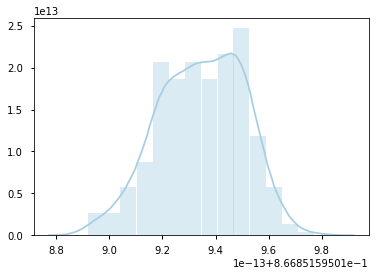

In [521]:
sns.distplot(cpm(raw.T, log=None, scale=1e4).mean(axis=0))

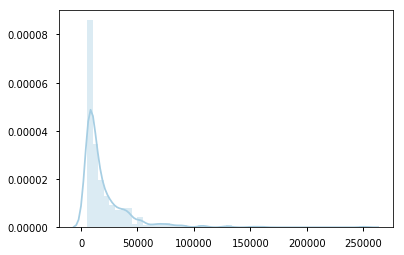

In [410]:
sns.distplot(raw.T.sum())

In [ ]:
def plot_boxplots(cluster=3, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    _cluster = raw[raw.join(clusters).ident == cluster]
    _n = _cluster.shape[0]
    expressed = (_cluster > 0).sum() > 3
    
    _chrom = _cluster.T[expressed].join(fbgn2chrom)
    _chrom = _chrom[~_chrom.chrom.isnull()].copy()
    _chrom.chrom = [x.lstrip('chr') for x in _chrom.chrom]

    _x = _chrom[_chrom.chrom == 'X'].drop('chrom', axis=1).mean(axis=1)
    _x.name = 'X'

    _a = _chrom[_chrom.chrom.isin([x.lstrip('chr') for x in AUTOSOMES])].set_index('chrom', append=True).mean(axis=1).unstack()
    _a.name = 'Autosome'
    _amed = _a.median().median()

    sns.boxplot(data=pd.concat([_x, _a], axis=1), fliersize=0, notch=True, ax=ax)
    ax.axhline(_amed, ls='--', c='k')
    ax.set_title(f'Cluster {cluster} (n={_n})')
    
fig, (ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(10, 10))
plot_boxplots(3, ax=ax1)
plot_boxplots(4, ax=ax2)

plt.suptitle('Raw Read Counts')
ax1.set_ylabel('Raw Read Count')
ax1.set_ylim(0, 15)
fig.tight_layout(rect=[0, 0, 1, .90])

In [523]:
def munge(df, norm_func=None, num_cells=3, ax=None, xlabel=None, ylabel=None, norm_kw=None, **kwargs):
    defaults = {
        'fliersize': 0,
        'notch': True
    }
    defaults.update(kwargs)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    expressed = ((df > 0).sum(axis=1) > num_cells)
    
    if norm_func is None:
        _norm = df
    else:
        if norm_kw is None:
            norm_kw = {}
            
        _norm = norm_func(df[expressed], **norm_kw)
        
    dat = _norm.mean(axis=1)
    dat.name = '_counts'
    
    sns.boxplot(x='chrom', y='_counts', data=pd.concat([dat, fbgn2chrom], axis=1), ax=ax, **defaults)
    
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

(0, 20)

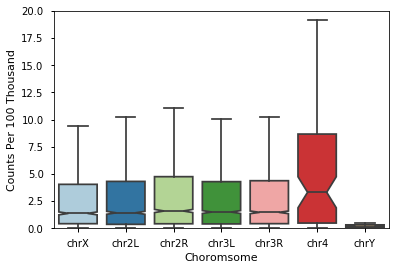

In [536]:
munge(raw.T, norm_func=cpm, xlabel='Choromsome', ylabel='Counts Per 100 Thousand', order=CHROMS, norm_kw={'scale': 1e5})
ax = plt.gca()
ax.set_ylim(0, 20)

In [552]:
def parse_attrs(attrs):
    regex = re.compile(r'(\w+)\s+"(.*?)";')
    return {k: v for k, v in re.findall(regex, contents[8])}

lens = []
with open('/data/LCDB/lcdb-references/dmel/r6-16/gtf/dmel_r6-16.gtf') as fh:
    for row in fh:
        contents = row.strip().split('\t')
        
        if len(contents) < 7:
            continue
            
        if contents[2] == 'gene':
            length = int(contents[4]) - int(contents[3])
            attrs = parse_attrs(contents[8])
            lens.append((attrs['gene_id'], length))

In [559]:
lengths = pd.DataFrame(lens, columns=['FBgn', 'length']).set_index('FBgn')

In [ ]:
def rpkm(df):
    _cpm = cpm(df)

# Combined

In [112]:
biomarkers = pd.read_csv('../../output/combined_ovary_and_testis_scRNAseq_pilot/biomarkers.tsv', sep='\t')
biomarkers.rename(columns={'gene': 'FBgn'}, inplace=True)

In [113]:
biomarkers['gene_symbol'] = biomarkers['FBgn'].apply(lambda x: fbgn2symbol[x])
biomarkers.set_index(['FBgn', 'gene_symbol'], inplace=True)

In [114]:
mask = (biomarkers.p_val_adj < 1e-4) & (biomarkers['pct.2'] < 0.1)

In [115]:
select_biomarkers = biomarkers[mask].sort_values('avg_logFC', ascending=False).sort_values('cluster')

In [116]:
_for_out = select_biomarkers[~select_biomarkers.index.get_level_values(1).str.startswith('CG') & ~select_biomarkers.index.get_level_values(1).str.startswith('CR')]

In [120]:
header = [
    'cluster', 
    'p_val',
    'p_val_adj', 
    'avg_logFC', 
    'pct.1', 
    'pct.2', 
]

In [122]:
_for_out[header].to_csv('../../output/figures/2017-12-05_for_brian/combined_biomarkers_subset.tsv', sep='\t')

In [138]:
biomarkers[biomarkers.cluster == 8].sort_index(level=1).index.get_in

,,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster
FBgn,gene_symbol,,,,,,
FBgn0004364,18w,8.445568e-05,0.319195,0.548,0.223,1.000000e+00,8
FBgn0250848,26-29-p,5.424959e-38,1.058528,0.881,0.708,6.495846e-34,8
FBgn0262739,AGO1,2.296434e-05,0.344956,0.976,0.821,2.749750e-01,8
FBgn0052626,AMPdeam,9.086121e-12,0.531799,1.000,0.800,1.087972e-07,8
FBgn0264855,AP-2alpha,4.447681e-05,0.258136,0.667,0.524,5.325654e-01,8
FBgn0036372,Abp1,6.116228e-10,0.373687,0.690,0.271,7.323571e-06,8
FBgn0263998,Ack-like,7.736404e-10,0.344333,0.738,0.307,9.263570e-06,8
FBgn0000043,Act42A,2.238066e-41,1.146198,1.000,0.990,2.679860e-37,8
FBgn0000042,Act5C,8.520934e-45,1.261630,1.000,0.974,1.020297e-40,8
